In [30]:
import math
class C45:

	"""Creates a decision tree with C4.5 algorithm"""
	def __init__(self, pathToData,pathToNames):
		self.filePathToData = pathToData
		self.filePathToNames = pathToNames
		self.data = []
		self.classes = []
		self.numAttributes = -1 
		self.attrValues = {}
		self.attributes = []
		self.tree = None

	def fetchData(self):
		with open(self.filePathToNames, "r") as file:
			classes = file.readline()
			self.classes = [x.strip() for x in classes.split(", ")]
			#add attributes
			for line in file:
				[attribute, values] = [x.strip() for x in line.split(":")]
				values = [x.strip() for x in values.split(", ")]
				self.attrValues[attribute] = values
		self.numAttributes = len(self.attrValues.keys())
		self.attributes = list(self.attrValues.keys())
		with open(self.filePathToData, "r") as file:
			for line in file:
				row = [x.strip() for x in line.split(",")]
				if row != [] or row != [""]:
					self.data.append(row)

	def preprocessData(self):
		for index,row in enumerate(self.data):
			for attr_index in range(self.numAttributes):
				if(not self.isAttrDiscrete(self.attributes[attr_index])):
					self.data[index][attr_index] = float(self.data[index][attr_index])

	def printTree(self):
		self.printNode(self.tree)

	def printNode(self, node, indent=""):
		if not node.isLeaf:
			if node.threshold is None:
				#discrete
				for index,child in enumerate(node.children):
					if child.isLeaf:
						print(indent + node.label + " = " + attributes[index] + " : " + child.label)
					else:
						print(indent + node.label + " = " + attributes[index] + " : ")
						self.printNode(child, indent + "	")
			else:
				#numerical
				leftChild = node.children[0]
				rightChild = node.children[1]
				if leftChild.isLeaf:
					print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
				else:
					print(indent + node.label + " <= " + str(node.threshold)+" : ")
					self.printNode(leftChild, indent + "	")

				if rightChild.isLeaf:
					print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
				else:
					print(indent + node.label + " > " + str(node.threshold) + " : ")
					self.printNode(rightChild , indent + "	")



	def generateTree(self):
		self.tree = self.recursiveGenerateTree(self.data, self.attributes)

	def recursiveGenerateTree(self, curData, curAttributes):
		allSame = self.allSameClass(curData)

		if len(curData) == 0:
			#Fail
			return Node(True, "Fail", None)
		elif allSame is not False:
			#return a node with that class
			return Node(True, allSame, None)
		elif len(curAttributes) == 0:
			#return a node with the majority class
			majClass = self.getMajClass(curData)
			return Node(True, majClass, None)
		else:
			(best,best_threshold,splitted) = self.splitAttribute(curData, curAttributes)
			remainingAttributes = curAttributes[:]
			remainingAttributes.remove(best)
			node = Node(False, best, best_threshold)
			node.children = [self.recursiveGenerateTree(subset, remainingAttributes) for subset in splitted]
			return node

	def getMajClass(self, curData):
		freq = [0]*len(self.classes)
		for row in curData:
			index = self.classes.index(row[-1])
			freq[index] += 1
		maxInd = freq.index(max(freq))
		return self.classes[maxInd]


	def allSameClass(self, data):
		for row in data:
			if row[-1] != data[0][-1]:
				return False
		return data[0][-1]

	def isAttrDiscrete(self, attribute):
		if attribute not in self.attributes:
			raise ValueError("Attribute not listed")
		elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
			return False
		else:
			return True

	def splitAttribute(self, curData, curAttributes):
		splitted = []
		maxEnt = -1*float("inf")
		best_attribute = -1
		#None for discrete attributes, threshold value for continuous attributes
		best_threshold = None
		for attribute in curAttributes:
			indexOfAttribute = self.attributes.index(attribute)
			if self.isAttrDiscrete(attribute):
				#split curData into n-subsets, where n is the number of 
				#different values of attribute i. Choose the attribute with
				#the max gain
				valuesForAttribute = self.attrValues[attribute]
				subsets = [[] for a in valuesForAttribute]
				for row in curData:
					for index in range(len(valuesForAttribute)):
						if row[index] == valuesForAttribute[index]:
							subsets[index].append(row)
							break
				e = gain(curData, subsets)
				if e > maxEnt:
					maxEnt = e
					splitted = subsets
					best_attribute = attribute
					best_threshold = None
			else:
				#sort the data according to the column.Then try all 
				#possible adjacent pairs. Choose the one that 
				#yields maximum gain
				curData.sort(key = lambda x: x[indexOfAttribute])
				for j in range(0, len(curData) - 1):
					if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
						threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
						less = []
						greater = []
						for row in curData:
							if(row[indexOfAttribute] > threshold):
								greater.append(row)
							else:
								less.append(row)
						e = self.gain(curData, [less, greater])
						if e >= maxEnt:
							splitted = [less, greater]
							maxEnt = e
							best_attribute = attribute
							best_threshold = threshold
		return (best_attribute,best_threshold,splitted)

	def gain(self,unionSet, subsets):
		#input : data and disjoint subsets of it
		#output : information gain
		S = len(unionSet)
		#calculate impurity before split
		impurityBeforeSplit = self.entropy(unionSet)
		#calculate impurity after split
		weights = [len(subset)/S for subset in subsets]
		impurityAfterSplit = 0
		for i in range(len(subsets)):
			impurityAfterSplit += weights[i]*self.entropy(subsets[i])
		#calculate total gain
		totalGain = impurityBeforeSplit - impurityAfterSplit
		return totalGain

	def entropy(self, dataSet):
		S = len(dataSet)
		if S == 0:
			return 0
		num_classes = [0 for i in self.classes]
		for row in dataSet:
			classIndex = list(self.classes).index(row[-1])
			num_classes[classIndex] += 1
		num_classes = [x/S for x in num_classes]
		ent = 0
		for num in num_classes:
			ent += num*self.log(num)
		return ent*-1


	def log(self, x):
		if x == 0:
			return 0
		else:
			return math.log(x,2)

class Node:
	def __init__(self,isLeaf, label, threshold):
		self.label = label
		self.threshold = threshold
		self.isLeaf = isLeaf
		self.children = []

In [31]:
import pdb
c1 = C45("adult.data", "adult.names")
c1.fetchData()
c1.preprocessData()
c1.generateTree()
c1.printTree()

NameError: name 'gain' is not defined

In [4]:
## 原始資料長度
print(f'training_data：{len(training_data)} records')
print(f'test_data：{len(test_data)} records')

training_data：32561 records
test_data：16281 records


In [5]:
## 命名欄位
training_data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
test_data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
feature_cols = ['age','workclass','fnlwgt','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country']
training_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
test_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [7]:
for column in training_data.columns:
    print(training_data[column].value_counts())
    
## education跟education-num數量一樣所以取education-num即可，故刪除education
training_data = training_data.drop(columns=['education'])
test_data = test_data.drop(columns=['education'])

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: age, Length: 73, dtype: int64
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
164190    13
203488    13
123011    13
148995    12
121124    12
          ..
232784     1
325573     1
140176     1
318264     1
257302     1
Name: fnlwgt, Length: 21648, dtype: int64
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
9     10501
10     7291

In [8]:
# label=y，other=X
# label = df['label']
# for i in range(len(label)):
#     if (label[i] == '<=50K'):
#         label[i] = 0
#     elif (label[i]=='>50K'):
#         label[i] = 1
# df['label'] = label
# df
convert = {"label" :{"<=50K":0, ">50K":1}}
training_data = training_data.replace(convert)
convert = {"label" :{"<=50K.":0, ">50K.":1}}
test_data = test_data.replace(convert)
training_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [9]:
test_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
16277,64,?,321403,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,0
16278,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
16279,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [10]:
# 缺失值數量
print("=======training_data=======")
for col,cnt in zip(training_data.columns,(training_data=='?').sum(axis = 0)):
    if cnt > 0:
        print(str(col) + ': ' + str(cnt) + ' records has missing value')
        

print("=======test_data=======")
for col,cnt in zip(test_data.columns,(test_data=='?').sum(axis = 0)):
    if cnt > 0:
        print(str(col) + ': ' + str(cnt) + ' records has missing value')

=======training_data=======
workclass: 1836 records has missing value
occupation: 1843 records has missing value
native-country: 583 records has missing value
=======test_data=======
workclass: 963 records has missing value
occupation: 966 records has missing value
native-country: 274 records has missing value


In [11]:
training_data = training_data[training_data['workclass']!='?']       
training_data = training_data[training_data['occupation']!='?']      
training_data = training_data[training_data['native-country']!='?']   

test_data = test_data[test_data['workclass']!='?']       
test_data = test_data[test_data['occupation']!='?']      
test_data = test_data[test_data['native-country']!='?']   

## 刪除缺失值後資料長度
print(f'training_data：{len(training_data)} records')
print(f'test_data：{len(test_data)} records')

training_data：30162 records
test_data：15060 records


In [12]:
# 確認無缺失值
print("=======training_data=======")
for col,cnt in zip(training_data.columns,(training_data=='?').sum(axis = 1)):
    if cnt == 0:
        print(str(col) + ': ' + str(cnt) + ' records')
        
        
print("=======test_data=======")    
for col,cnt in zip(test_data.columns,(test_data=='?').sum(axis = 1)):
    if cnt == 0:
        print(str(col) + ': ' + str(cnt) + ' records')

=======training_data=======
age: 0 records
workclass: 0 records
fnlwgt: 0 records
education-num: 0 records
marital-status: 0 records
occupation: 0 records
relationship: 0 records
race: 0 records
sex: 0 records
capital-gain: 0 records
capital-loss: 0 records
hours-per-week: 0 records
native-country: 0 records
label: 0 records
=======test_data=======
age: 0 records
workclass: 0 records
fnlwgt: 0 records
education-num: 0 records
marital-status: 0 records
occupation: 0 records
relationship: 0 records
race: 0 records
sex: 0 records
capital-gain: 0 records
capital-loss: 0 records
hours-per-week: 0 records
native-country: 0 records
label: 0 records


In [13]:
training_data = pd.get_dummies(training_data)
test_data = pd.get_dummies(test_data)
print(training_data.info())
print(test_data.info())
feature_cols = training_data.columns
# print(*feature_cols,sep='\n')
training_data['label'] = training_data['label'].astype('int64')
test_data['label'] = test_data['label'].astype('int64')
for column in training_data.columns:
    if column not in test_data.columns:
        test_data[column] = 0
        print(training_data[column])
        print(test_data[column])
        break
print(training_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 89 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        30162 non-null  int64
 1   fnlwgt                                     30162 non-null  int64
 2   education-num                              30162 non-null  int64
 3   capital-gain                               30162 non-null  int64
 4   capital-loss                               30162 non-null  int64
 5   hours-per-week                             30162 non-null  int64
 6   label                                      30162 non-null  int64
 7   workclass_Federal-gov                      30162 non-null  uint8
 8   workclass_Local-gov                        30162 non-null  uint8
 9   workclass_Private                          30162 non-null  uint8
 10  workclass_Self-emp-inc                     301

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15060 entries, 0 to 16280
Data columns (total 89 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        15060 non-null  int64
 1   fnlwgt                                     15060 non-null  int64
 2   education-num                              15060 non-null  int64
 3   capital-gain                               15060 non-null  int64
 4   capital-loss                               15060 non-null  int64
 5   hours-per-week                             15060 non-null  int64
 6   label                                      15060 non-null  int64
 7   workclass_Federal-gov                      15060 non-null  uint8
 8   workclass_Local-gov                        15060 non-null  uint8
 9   workclass_Private                          15060 non-null  uint8
 10  workclass_Self-emp-inc                     150

In [14]:
X = training_data.drop('label',axis=1)
y = training_data['label']
# print(Xt.columns)
Xt = test_data.drop('label',axis=1)
Xt.columns = X.columns
yt = test_data['label']
print(X)
print(y)

       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0       39   77516             13          2174             0              40   
1       50   83311             13             0             0              13   
2       38  215646              9             0             0              40   
3       53  234721              7             0             0              40   
4       28  338409             13             0             0              40   
...    ...     ...            ...           ...           ...             ...   
32556   27  257302             12             0             0              38   
32557   40  154374              9             0             0              40   
32558   58  151910              9             0             0              40   
32559   22  201490              9             0             0              20   
32560   52  287927              9         15024             0              40   

       workclass_Federal-go

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test
# xx_train,xx_test,yy_train,yy_test = train_test_split(Xt,yt,test_size=0.2)

In [16]:
# from sklearn.tree import DecisionTreeClassifier
# # dt = DecisionTreeClassifier()
# dt = DecisionTreeClassifier(criterion='entropy',max_depth=19, max_leaf_nodes = 92)
# dt.fit(X_train,y_train)
# dt.score(X_test,y_test)

In [17]:
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier()
# dt = DecisionTreeClassifier(criterion='entropy',max_depth=19, max_leaf_nodes = 92)
# dt.fit(Xt,yt)
# dt.score(Xt,yt)
# # X_test.info()

[0.7434112381899552, 0.8216476048400464, 0.8365655561080723, 0.8365655561080723, 0.837228576164429, 0.8471738770097795, 0.8483341621084037, 0.8529753025029008, 0.8524780374606332, 0.8528095474888115, 0.8531410575169899, 0.8524780374606332, 0.8524780374606332, 0.8543013426156141, 0.8552958727001492, 0.8552958727001492, 0.8552958727001492, 0.8552958727001492]
[0.7543160690571049, 0.8246347941567065, 0.8392430278884462, 0.8392430278884462, 0.8409694555112882, 0.845883134130146, 0.8385790172642762, 0.8438247011952191, 0.8572377158034529, 0.8573705179282869, 0.8575697211155379, 0.8555112881806108, 0.8555112881806108, 0.8591633466135458, 0.8586985391766269, 0.8587649402390438, 0.8587649402390438, 0.8586985391766269]


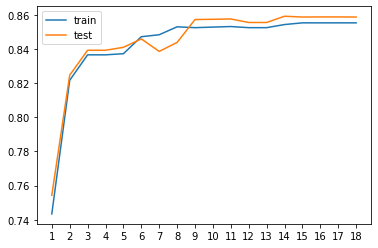

In [18]:
import numpy as np
import matplotlib.pyplot as plt

ax = []
a_train = []
a_test = []
for depth in range(1,19):
    ax.append(depth)
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=depth, max_leaf_nodes = 92)
    dt.fit(X_train,y_train)
    a_train.append(dt.score(X_test,y_test))
#     dt.fit(Xt,yt)
    a_test.append(dt.score(Xt,yt))
    
print(a_train)
plt.plot(ax, a_train,label='train')
print(a_test)
plt.plot(ax, a_test,label='test')
plt.legend()
plt.xticks(ax)
plt.show()

In [19]:
print("=======training_data=======")
train_best = max(a_train)
for i in range(len(a_train)):
    if a_train[i]==train_best:
        print(f' depth : {i} , acc : {train_best:.3f}')
        break
        
print("=======test_data=======")
test_best = max(a_test)
for i in range(len(a_train)):
    if a_test[i]==test_best:
        print(f' depth : {i} , acc : {test_best:.3f}')
        break
best_depth = i+1

=======training_data=======
 depth : 14 , acc : 0.855
=======test_data=======
 depth : 13 , acc : 0.859


[0.7434112381899552, 0.8120338140228742, 0.8216476048400464, 0.8365655561080723, 0.8365655561080723, 0.8365655561080723, 0.8365655561080723, 0.8365655561080723, 0.8365655561080723, 0.8365655561080723, 0.8365655561080723, 0.8446875517984419, 0.8446875517984419, 0.8446875517984419, 0.8446875517984419, 0.8453505718547986, 0.8461793469252444, 0.8461793469252444, 0.8483341621084037, 0.848499917122493, 0.8488314271506713, 0.8498259572352064, 0.850488977291563, 0.850488977291563, 0.850488977291563, 0.850488977291563, 0.8503232222774739, 0.8503232222774739, 0.8503232222774739, 0.8503232222774739, 0.8503232222774739, 0.8503232222774739, 0.8506547323056523, 0.8506547323056523, 0.8506547323056523, 0.8506547323056523, 0.8511519973479198, 0.8511519973479198, 0.8511519973479198, 0.8511519973479198, 0.8511519973479198, 0.8511519973479198, 0.8511519973479198, 0.8513177523620089, 0.8513177523620089, 0.8513177523620089, 0.8513177523620089, 0.8521465274324548, 0.8529753025029008, 0.8529753025029008, 0.85

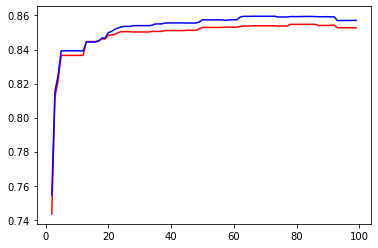

In [20]:
import numpy as np
import matplotlib.pyplot as plt

ax = []
a_train = []
a_test = []
for node in range(2,100):
    ax.append(node)
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth, max_leaf_nodes = node)
    dt.fit(X_train,y_train)
    a_train.append(dt.score(X_test,y_test))
#     dt.fit(Xt,yt)
    a_test.append(dt.score(Xt,yt))
    
print(a_train)
plt.plot(ax, a_train, 'r')
print(a_test)
plt.plot(ax, a_test, 'b')
plt.show()

In [21]:
best = max(a_test)
for i in range(len(a_test)):
    if a_test[i]==best:
        print(i+1)
best_node = i+1

65
66
67
68
69
70
71
72


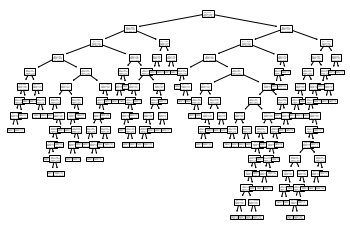

In [22]:
import matplotlib.pyplot as plt
from sklearn import tree
dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth, max_leaf_nodes = best_node)
dt.fit(X_train,y_train)
tree.plot_tree(dt)
plt.show()

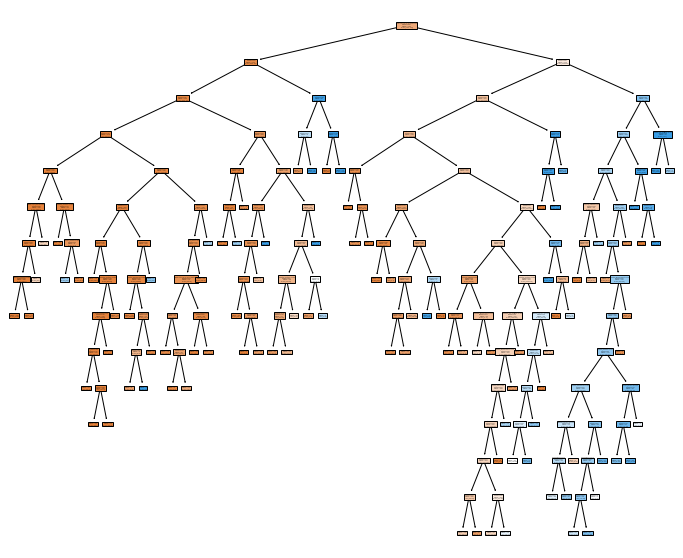

In [24]:
fig = plt.figure(figsize=(12,10))
# _ = tree.plot_tree(dt,filledTrue)
_ = tree.plot_tree(dt, feature_names = feature_cols, filled = True)

In [ ]:
# cyj #